# Introduction

This notebook presents my approach to the problem called **_"Build a model that predicts the number of hits per session."_** from Trivago.

## Table of Content

1. [Summary Information](#summary)
2. [Analysis of missing values](#missing_values)
3. [Outliers detection](#outliers_detection)
4. [Missing values imputation](#impute_missing)
5. [Prediction](#prediction)<br>
   5.1 [Linear Regression](#lr)<br>
   5.2 [Decision Tree](#dt)<br>
   5.3 [Random Forest](#rf)<br>
   5.4 [XGBoost](#xbg)
6. [Evaluation](#evaluation)
7. [Conclusion](#conclusion)

In [1]:
from string import ascii_letters
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 

## 1. Summary information
<a id="summary"></a>

In [3]:
df = pd.read_csv('datasets/case_study/ML Data Scientist Case Study Data.csv', sep=";")
#df = pd.read_csv('C:/Users/aghenda/Downloads/ML Data Scientist Case Study Data.csv', sep=";")

In [4]:
train = df.loc[df.hits != '\\N'] # train set 
test = df.loc[df.hits == '\\N'] # test set

In [5]:
print('Training dataset:\n', train.head(), '\n','-'*100, '\nTest dataset:\n', test.head())

Training dataset:
    row_num locale day_of_week  hour_of_day  agent_id  entry_page path_id_set  \
1   988680     L2    Thursday           22        10        2113     31965;0   
2   988679     L4    Saturday           21         2        2100     0;78464   
3   988678     L3    Saturday           19         8        2113       51462   
4   988677     L2     Tuesday            6        10        2116     31931;0   
5   988676     L3      Monday            1         8        2100           0   

   traffic_type session_durantion hits  
1             2                49   14  
2             1              1892   14  
3             6                 0    1  
4             1                 2    3  
5             1                 0    2   
 ---------------------------------------------------------------------------------------------------- 
Test dataset:
     row_num locale day_of_week  hour_of_day  agent_id  entry_page  \
0    988681     L6      Monday           17         1        2111 

In [6]:
print('Number train entries:', len(train), ', Number test entries:', len(test))

Number train entries: 619235 , Number test entries: 369446


In [7]:
print('train column names and types:', train.dtypes, sep='\n')
print('-'*28)
print('test column names and types:', test.dtypes, sep='\n')

train column names and types:
row_num               int64
locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion    object
hits                 object
dtype: object
----------------------------
test column names and types:
row_num               int64
locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion    object
hits                 object
dtype: object


In [8]:
print('Train data set:  \n\n', train.count(), '\n')
print('Test data set:  \n\n', test.count(), '\n')

Train data set:  

 row_num              619235
locale               619235
day_of_week          619235
hour_of_day          619235
agent_id             619235
entry_page           619235
path_id_set          616082
traffic_type         619235
session_durantion    619235
hits                 619235
dtype: int64 

Test data set:  

 row_num              369446
locale               369446
day_of_week          369446
hour_of_day          369446
agent_id             369446
entry_page           369446
path_id_set          367710
traffic_type         369446
session_durantion    369446
hits                 369446
dtype: int64 



In [9]:
print('Columns and types :  \n\n', train.dtypes, '\n')

Columns and types :  

 row_num               int64
locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion    object
hits                 object
dtype: object 



## 2. Handling missing values
<a id="missing_values"></a>

In [10]:
# We replace missing values denoted \N with NaN
train.replace('\\N', np.nan, inplace=True)
test.replace('\\N', np.nan, inplace=True)

In [11]:
df_columns = list(df.columns)
for column in df_columns:
    print('All entries in train set have non-null', column ,':', ~train[column].isnull().any())

All entries in train set have non-null row_num : True
All entries in train set have non-null locale : True
All entries in train set have non-null day_of_week : True
All entries in train set have non-null hour_of_day : True
All entries in train set have non-null agent_id : True
All entries in train set have non-null entry_page : True
All entries in train set have non-null path_id_set : False
All entries in train set have non-null traffic_type : True
All entries in train set have non-null session_durantion : False
All entries in train set have non-null hits : True


In [12]:
for column in df_columns:
    print('All entries in test set have non-null', column ,':', ~test[column].isnull().any())

All entries in test set have non-null row_num : True
All entries in test set have non-null locale : True
All entries in test set have non-null day_of_week : True
All entries in test set have non-null hour_of_day : True
All entries in test set have non-null agent_id : True
All entries in test set have non-null entry_page : True
All entries in test set have non-null path_id_set : False
All entries in test set have non-null traffic_type : True
All entries in test set have non-null session_durantion : False
All entries in test set have non-null hits : False


Train data set: **path_id_set** and **session_durantion** contains missing values <br>
Test data set: **path_id_set**,  **session_durantion** and **hits** contains missing values

Let's now look at the proportion of missing values.

In [13]:
df_columns = list(df.columns)
for column in df_columns:
    print('Percentage of missing values for feature', column ,':', round((train[column].isnull().sum()/len(train))*100, 2), '%')

Percentage of missing values for feature row_num : 0.0 %
Percentage of missing values for feature locale : 0.0 %
Percentage of missing values for feature day_of_week : 0.0 %
Percentage of missing values for feature hour_of_day : 0.0 %
Percentage of missing values for feature agent_id : 0.0 %
Percentage of missing values for feature entry_page : 0.0 %
Percentage of missing values for feature path_id_set : 0.51 %
Percentage of missing values for feature traffic_type : 0.0 %
Percentage of missing values for feature session_durantion : 0.07 %
Percentage of missing values for feature hits : 0.0 %


In [14]:
df_columns = list(df.columns)
for column in df_columns:
    print('Percentage of missing values for feature', column ,':', round((test[column].isnull().sum()/len(test))*100, 2), '%')

Percentage of missing values for feature row_num : 0.0 %
Percentage of missing values for feature locale : 0.0 %
Percentage of missing values for feature day_of_week : 0.0 %
Percentage of missing values for feature hour_of_day : 0.0 %
Percentage of missing values for feature agent_id : 0.0 %
Percentage of missing values for feature entry_page : 0.0 %
Percentage of missing values for feature path_id_set : 0.47 %
Percentage of missing values for feature traffic_type : 0.0 %
Percentage of missing values for feature session_durantion : 0.07 %
Percentage of missing values for feature hits : 100.0 %


Globally the proportions of missing values are very low for the train set. <br>
I do not think that it is advisable to impute **path_id_set**. Therefore, I decide to drop these rows. <br>
For **session_durantion**, I will find a strategy to impute the missing values since they only represent 0.07%.

In the test set, same observations can be made.The percentage of missing values for hits is 100% but it is normal since we split our train / test set based on these missing values.

In [15]:
train.dropna(subset = ['path_id_set'], inplace=True)
test.dropna(subset = ['path_id_set'], inplace=True)

### Missing values: session_duration

In [16]:
# Let's have a quick look at the rows for which session_durantion is missing.
train[train.session_durantion.isnull()].head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
3562,985119,L3,Monday,0,8,8101,0,1,NaN,1
9948,978733,L2,Friday,7,7,8101,0,1,NaN,1
14262,974419,L3,Saturday,18,13,8101,0,1,NaN,1
20065,968616,L6,Tuesday,16,9,8101,0,1,NaN,1
21926,966755,L3,Wednesday,4,9,8101,0,1,NaN,1
24090,964591,L3,Tuesday,3,8,8101,0,1,NaN,1
24123,964558,L2,Tuesday,11,2,8101,0,1,NaN,1
26247,962434,L2,Thursday,7,2,8101,0,1,NaN,1
26990,961691,L2,Monday,11,7,8101,0,1,NaN,1
30190,958491,L1,Wednesday,2,8,8101,0,1,NaN,1


In [17]:
test[test.session_durantion.isnull()].head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
1153,987528,L3,Thursday,0,0,2226,34911;0,1,NaN,NaN
5171,983510,L6,Friday,15,6,8101,0,1,NaN,NaN
5349,983332,L2,Friday,19,7,8101,0,1,NaN,NaN
5563,983118,L3,Tuesday,14,9,8101,0,1,NaN,NaN
7816,980865,L1,Saturday,6,6,8101,0,1,NaN,NaN
9351,979330,L1,Sunday,14,7,8101,0,1,NaN,NaN
12791,975890,L6,Sunday,15,8,8101,0,1,NaN,NaN
15200,973481,L3,Saturday,15,9,8101,0,1,NaN,NaN
32428,956253,L3,Tuesday,0,9,8101,0,1,NaN,NaN
33574,955107,L6,Wednesday,9,9,8101,0,1,NaN,NaN


A first observation we can make is that it seems to particularly concern the entry page 8101, the traffic_type 1 and the path_id_set is 0. But let's dig more into that to understand what's happening.

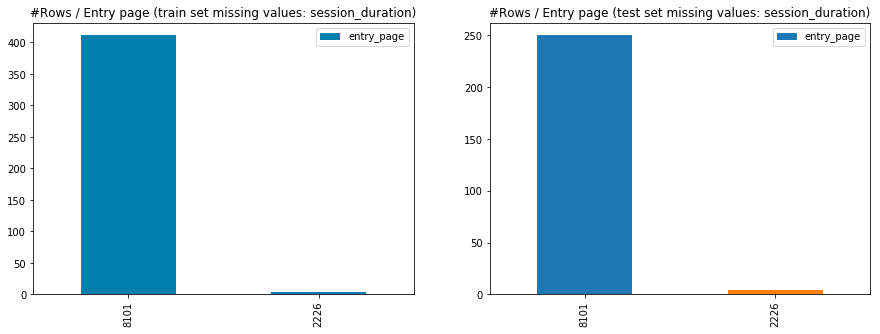

In [18]:
f, ax = plt.subplots(1,2, figsize=(15,5))
train[train.session_durantion.isnull()].entry_page.value_counts().plot('bar', ax=ax[0], color='#007faf', legend=True, title='#Rows / Entry page (train set missing values: session_duration)')
test[test.session_durantion.isnull()].entry_page.value_counts().plot('bar', ax=ax[1], legend=True, title='#Rows / Entry page (test set missing values: session_duration)')

Now it is obvious that there is a problem with the entry page 8101.

In [19]:
print('Train set: Traffic type for which the session_duration is missing:', train[train.session_durantion.isnull()].traffic_type.unique())
print('Test set: Traffic type for which the session_duration is missing:', test[test.session_durantion.isnull()].traffic_type.unique())

Train set: Traffic type for which the session_duration is missing: [1]
Test set: Traffic type for which the session_duration is missing: [1]


In [20]:
print('Train set: proportion of rows with entry page 8101 and traffic type 1 concerned by the absence of session_durantion:', round(len(train[(train['session_durantion'].isnull()) & (train.entry_page == 8101) & (train.traffic_type == 1)])/len(train[(train.entry_page == 8101)])*100, 2), '%')
print('Test set: proportion of rows with entry page 8101 and traffic type 1 concerned by the absence of session_durantion:', round(len(test[(test['session_durantion'].isnull()) & (test.entry_page == 8101) & (test.traffic_type == 1)])/len(test[(test.entry_page == 8101)])*100, 2), '%')

Train set: proportion of rows with entry page 8101 and traffic type 1 concerned by the absence of session_durantion: 98.09 %
Test set: proportion of rows with entry page 8101 and traffic type 1 concerned by the absence of session_durantion: 99.21 %


Traffic type 1 is the only one concerned by the missing values. I believe that there might be a problem with the entry page 8101 from the traffic type 1. I would crosscheck that with the web dev team to have more information. 

Now we want to input the missing values. However, the distribution of data is not normal and there are values that we believe are outliers. We will first deal with them before we use statistical measures to input the missing values.

## 3. Outliers detection
<a id="outliers_detection"></a>

### Z-score

In [21]:
def zscore(series, threshold=3):
    z_score = (series-np.mean(series))/np.std(series)
    return np.abs(z_score) > threshold

### Modified Z-score

In [22]:
def modified_zscore(series, threshold=3):
    modified_z_score = 0.6745*(series-np.median(series))/series.mad()
    return np.abs(modified_z_score) > threshold

### Isolation forest

In [23]:
from sklearn.ensemble import IsolationForest

In [24]:
def isolation_forest(series):
    clf = IsolationForest(behaviour='new', contamination='auto', random_state=0)
    series = series.values.reshape(-1, 1)
    clf.fit(series)
    return clf.predict(series)

### Comparing outliers detection techniques

In [25]:
def get_proportion(series, inf, sup):
    return round((len(series[(series > inf) & (series < sup)]) / len(series))*100, 2)

In [26]:
def outlier_print(title, inliers, series):
    print('Outlier detection: {} identified outliers outside of the range [{}, {}]. Resulting outlier proportion: {}%.'.format(title, round(min(inliers)), round(max(inliers)), get_proportion(series, max(inliers), max(series)+1)))

In [27]:
def outliers_detection(series):
    inliers_zscore = series[~zscore(series)]
    outlier_print('Z-Score', inliers_zscore, series)
    inliers_modified_zscore = series[~modified_zscore(series)]
    outlier_print('Modified Z-Score', inliers_modified_zscore, series)
    inliers_isolation_forest = series[isolation_forest(series) == 1]
    outlier_print('Isolation Forest', inliers_isolation_forest, series)

In [28]:
# I exclude the missing values to find the outliers
train_without_missing_session = train[~train.session_durantion.isnull()]

In [29]:
train_without_missing_session.session_durantion = train_without_missing_session.session_durantion.astype('int')
train_without_missing_session.hits = train_without_missing_session.hits.astype('int')

In [30]:
train_without_missing_session.dtypes

row_num               int64
locale               object
day_of_week          object
hour_of_day           int64
agent_id              int64
entry_page            int64
path_id_set          object
traffic_type          int64
session_durantion     int32
hits                  int32
dtype: object

##### Outliers detection: Session duration

In [31]:
outliers_detection(train_without_missing_session.session_durantion)

Outlier detection: Z-Score identified outliers outside of the range [0, 6245]. Resulting outlier proportion: 0.68%.
Outlier detection: Modified Z-Score identified outliers outside of the range [0, 2996]. Resulting outlier proportion: 3.33%.
Outlier detection: Isolation Forest identified outliers outside of the range [0, 579]. Resulting outlier proportion: 17.84%.


##### Outliers detection: Hits

In [32]:
outliers_detection(train_without_missing_session.hits)

Outlier detection: Z-Score identified outliers outside of the range [1, 135]. Resulting outlier proportion: 1.43%.
Outlier detection: Modified Z-Score identified outliers outside of the range [1, 86]. Resulting outlier proportion: 3.23%.
Outlier detection: Isolation Forest identified outliers outside of the range [2, 32]. Resulting outlier proportion: 13.88%.


We will use the Z-score that has the lowest proportion and drop the outliers.

In [33]:
def drop_outliers(df, column, mode=1):
    """ mode:
                1: Z-Score
                2: Modified Z-Score
                else: Isolation Forest
    """
    if mode == 1:
        inliers_zscore = df[column][~zscore(df[column])]
        max_inliers = round(max(inliers_zscore))
        df = df[df[column] < max_inliers] 
    elif mode == 2:
        inliers_modified_zscore = df[column][~modified_zscore(df[column])]
        max_inliers = round(max(inliers_modified_zscore))
        df = df[df[column] < max_inliers] 
    else:
        inliers_isolation_forest = df[column][isolation_forest(df[column]) == 1]
        max_inliers = round(max(inliers_isolation_forest))
        df = df[df[column] < max_inliers]    
    return df

In [34]:
train_without_missing_session = drop_outliers(train_without_missing_session, 'session_durantion', mode=1)

In [35]:
train_without_missing_session = drop_outliers(train_without_missing_session, 'hits', mode=1)

In [36]:
len(train_without_missing_session)

602070

In [37]:
# I concatenate missing sessions with the data set from which I removed outliers
train_only_missing_session = train[train.session_durantion.isnull()]
train = pd.concat([train_without_missing_session, train_only_missing_session])

## 4. Missing values imputation
<a id="impute_missing"></a>

### Feature: Session duration

c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


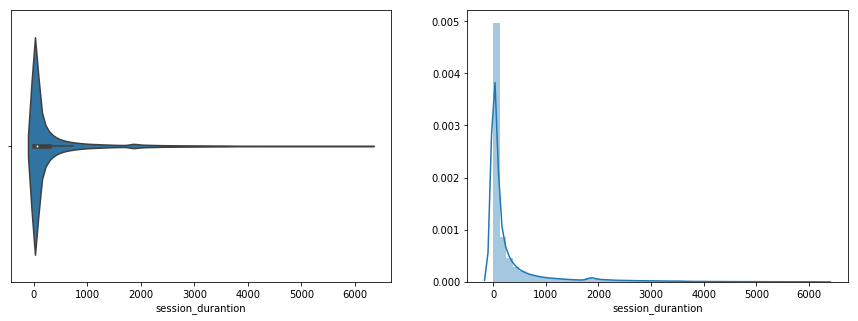

In [38]:
f, axes = plt.subplots(1, 2, figsize=(15,5))

sns.violinplot(train[~train.session_durantion.isnull()].session_durantion.astype('int32'), ax=axes[0])
sns.distplot(train[~train.session_durantion.isnull()].session_durantion.astype('int32'), ax=axes[1])

By looking at the boxplot and the distplot, we can make two observations:

1. Feature session_durantion is very skewed.
2. The majority of the data is concentrated between 0-1000

It makes me think that the mean would not be relevant. However, the median is this case makes more sense.

In [39]:
train.session_durantion.replace(np.nan, train.session_durantion.median(), inplace=True)

In [40]:
df_columns = list(df.columns)
for column in df_columns:
    print('All entries in train set have non-null', column ,':', ~train[column].isnull().any())

All entries in train set have non-null row_num : True
All entries in train set have non-null locale : True
All entries in train set have non-null day_of_week : True
All entries in train set have non-null hour_of_day : True
All entries in train set have non-null agent_id : True
All entries in train set have non-null entry_page : True
All entries in train set have non-null path_id_set : True
All entries in train set have non-null traffic_type : True
All entries in train set have non-null session_durantion : True
All entries in train set have non-null hits : True


## 5. Prediction
<a id="prediction"></a>

In [41]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import clone, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import make_scorer

In [42]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def root_mean_squared_error(y_actual, y_pred):
    rmse = sqrt(mean_squared_error(y_actual, y_pred))
    return rmse

In [43]:
models_scores = {}

### 5.1 Linear Regression
<a id="lr"></a>

In [78]:
def linear_regression_1(df, n_folds):
    print('Model 1: Standard Scaler + Linear Regression')
    numeric_features = ['session_durantion']
    categorical_features = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type']

    numeric_transformer = Pipeline(steps=[
        ('standard', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear_regression', LinearRegression())])
    
    X = df.drop(columns=['row_num', 'hits', 'path_id_set'])
    y = df['hits']
    
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rmse_kfold_test = []
    rmse_kfold_train = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        rmse_kfold_test.append(root_mean_squared_error(y_test, np.round(np.maximum(y_pred_test, 0))))
        rmse_kfold_train.append(root_mean_squared_error(y_train, np.round(np.maximum(y_pred_train, 0))))
        
    avg_rmse_kfold_train = sum(rmse_kfold_train) / len(rmse_kfold_train)
    avg_rmse_kfold_test = sum(rmse_kfold_test) / len(rmse_kfold_test)
    
    print('RMSE train:', avg_rmse_kfold_train)
    print('RMSE test:', avg_rmse_kfold_test)
    
    return avg_rmse_kfold_test

In [79]:
models_scores['model_1'] = linear_regression_1(train, 5)

Model 1: Standard Scaler + Linear Regression
RMSE train: 15.70668993180146
RMSE test: 15.71377748321334


In [81]:
def linear_regression_2(df, n_folds):
    print('Model 2: MinMax Scaler + Linear Regression')
    numeric_features = ['session_durantion']
    categorical_features = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type']

    numeric_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler())])
    
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear_regression', LinearRegression())])
    
    X = df.drop(columns=['row_num', 'hits', 'path_id_set'])
    y = df['hits']
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rmse_kfold_test = []
    rmse_kfold_train = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        rmse_kfold_test.append(root_mean_squared_error(y_test, np.round(np.maximum(y_pred_test, 0))))
        rmse_kfold_train.append(root_mean_squared_error(y_train, np.round(np.maximum(y_pred_train, 0))))
        
    avg_rmse_kfold_train = sum(rmse_kfold_train) / len(rmse_kfold_train)
    avg_rmse_kfold_test = sum(rmse_kfold_test) / len(rmse_kfold_test)
    
    print('RMSE train:', avg_rmse_kfold_train)
    print('RMSE test:', avg_rmse_kfold_test)
    
    return avg_rmse_kfold_test
    

In [82]:
models_scores['model_2'] = linear_regression_2(train, 5)

Model 2: MinMax Scaler + Linear Regression
RMSE train: 15.706691036575114
RMSE test: 15.713836400828859


In [83]:
def linear_regression_3(df, n_folds):
    print('Model 3: Robust Scaler + Linear Regression')
    numeric_features = ['session_durantion']
    categorical_features = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type']

    numeric_transformer = Pipeline(steps=[
        ('robust_scaler', RobustScaler())])
    
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear_regression', LinearRegression())])
    
    X = df.drop(columns=['row_num', 'hits', 'path_id_set'])
    y = df['hits']
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rmse_kfold_test = []
    rmse_kfold_train = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        rmse_kfold_test.append(root_mean_squared_error(y_test, np.round(np.maximum(y_pred_test, 0))))
        rmse_kfold_train.append(root_mean_squared_error(y_train, np.round(np.maximum(y_pred_train, 0))))
        
    avg_rmse_kfold_train = sum(rmse_kfold_train) / len(rmse_kfold_train)
    avg_rmse_kfold_test = sum(rmse_kfold_test) / len(rmse_kfold_test)
    
    print('RMSE train:', avg_rmse_kfold_train)
    print('RMSE test:', avg_rmse_kfold_test)
    
    return avg_rmse_kfold_test
    

In [84]:
models_scores['model_3'] = linear_regression_3(train, 5)

Model 3: Robust Scaler + Linear Regression
RMSE train: 15.706701542431478
RMSE test: 15.713797682123058


In [91]:
def linear_regression_4(df, n_folds):
    print('Model 4: Log Transformation + Linear Regression')
    numeric_features = ['session_durantion']
    categorical_features = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type']

    numeric_transformer = Pipeline(steps=[
        ('log_transform', FunctionTransformer(np.log1p, validate=True))])
    
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('linear_regression', LinearRegression())])
    
    X = df.drop(columns=['row_num', 'hits', 'path_id_set'])
    y = df['hits']
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rmse_kfold_test = []
    rmse_kfold_train = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        rmse_kfold_test.append(root_mean_squared_error(y_test, np.round(np.maximum(y_pred_test, 0))))
        rmse_kfold_train.append(root_mean_squared_error(y_train, np.round(np.maximum(y_pred_train, 0))))
        
    avg_rmse_kfold_train = sum(rmse_kfold_train) / len(rmse_kfold_train)
    avg_rmse_kfold_test = sum(rmse_kfold_test) / len(rmse_kfold_test)
    
    print('RMSE train:', avg_rmse_kfold_train)
    print('RMSE test:', avg_rmse_kfold_test)
    
    return avg_rmse_kfold_test
    

In [92]:
models_scores['model_4'] = linear_regression_4(train, 5)

Model 4: Log Transformation + Linear Regression
RMSE train: 14.50459408993547
RMSE test: 14.511520609012527


### 5.2 Decision Tree
<a id="dt"></a>

In [93]:
from sklearn.tree import DecisionTreeRegressor

In [94]:
def decision_tree_1(df, n_folds):
    print('Model 5: Log Transformation + Decision Tree + GridSearch')
    numeric_features = ['session_durantion']
    categorical_features = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type']

    numeric_transformer = Pipeline(steps=[
        ('log_transform', FunctionTransformer(np.log1p, validate=True))])
    
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('decision_tree', DecisionTreeRegressor(random_state=0))])
    
    X = df.drop(columns=['row_num', 'hits', 'path_id_set'])
    y = df['hits']
    
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    
    num_leafs = [10, 20, 50, 100, 200]
    depths = [10, 15]
    
    param_grid = [{'decision_tree__max_depth': depths,
              'decision_tree__min_samples_leaf':num_leafs}]
    
    
    grid = GridSearchCV(model, param_grid, cv=10, scoring=rmse_scorer, iid=False, return_train_score=True, error_score=np.nan, n_jobs=-1, verbose=10)
    grid.fit(X, y)
    print('Best Parameters:', grid.best_params_)
    best_model = clone(grid.best_estimator_)
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rmse_kfold_test = []
    rmse_kfold_train = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        y_pred_test = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        rmse_kfold_test.append(root_mean_squared_error(y_test, np.round(np.maximum(y_pred_test, 0))))
        rmse_kfold_train.append(root_mean_squared_error(y_train, np.round(np.maximum(y_pred_train, 0))))
        
    
    avg_rmse_kfold_train = sum(rmse_kfold_train) / len(rmse_kfold_train)
    avg_rmse_kfold_test = sum(rmse_kfold_test) / len(rmse_kfold_test)
    
    print('RMSE train:', avg_rmse_kfold_train)
    print('RMSE test:', avg_rmse_kfold_test)
    
    return avg_rmse_kfold_test
    
    

In [95]:
models_scores['model_5'] = decision_tree_1(train, 5)

Model 5: Log Transformation + Decision Tree + GridSearch
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 17.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 33.3min finished


Best Parameters: {'decision_tree__max_depth': 15, 'decision_tree__min_samples_leaf': 200}
RMSE train: 13.645908235520258
RMSE test: 13.761585920756403


In [98]:
def decision_tree_2(df, n_folds):
    print('Model 6: Robust Scaler + Decision Tree + GridSearch')
    numeric_features = ['session_durantion']
    categorical_features = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type']

    numeric_transformer = Pipeline(steps=[
        ('log_transform', RobustScaler())])
    
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('decision_tree', DecisionTreeRegressor(random_state=0))])
    
    X = df.drop(columns=['row_num', 'hits', 'path_id_set'])
    y = df['hits']
    
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    
    num_leafs = [10, 20, 50, 100, 200]
    depths = [10, 15]
    
    param_grid = [{'decision_tree__max_depth': depths,
              'decision_tree__min_samples_leaf':num_leafs}]
    
    
    grid = GridSearchCV(model, param_grid, cv=10, scoring=rmse_scorer, iid=False, return_train_score=True, error_score=np.nan, n_jobs=-1, verbose=10)
    grid.fit(X, y)
    print('Best Parameters:', grid.best_params_)
    best_model = clone(grid.best_estimator_)
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    rmse_kfold_test = []
    rmse_kfold_train = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        y_pred_test = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        rmse_kfold_test.append(root_mean_squared_error(y_test, np.round(np.maximum(y_pred_test, 0))))
        rmse_kfold_train.append(root_mean_squared_error(y_train, np.round(np.maximum(y_pred_train, 0))))
        
    
    avg_rmse_kfold_train = sum(rmse_kfold_train) / len(rmse_kfold_train)
    avg_rmse_kfold_test = sum(rmse_kfold_test) / len(rmse_kfold_test)
    
    print('RMSE train:', avg_rmse_kfold_train)
    print('RMSE test:', avg_rmse_kfold_test)
    
    return avg_rmse_kfold_test
    
    

In [99]:
models_scores['model_6'] = decision_tree_2(train, 5)

Model 6: Robust Scaler + Decision Tree + GridSearch
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 34.0min finished


Best Parameters: {'decision_tree__max_depth': 15, 'decision_tree__min_samples_leaf': 200}
RMSE train: 13.645908235520258
RMSE test: 13.761569516104458


### 5.3 Random Forest
<a id="rf"></a>

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [63]:
def random_forest(df, n_folds):
    print('Model 7: Log Transformation + Random Forest + RandomizedSearch')
    numeric_features = ['session_durantion']
    categorical_features = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type']

    numeric_transformer = Pipeline(steps=[
        ('log_transform', FunctionTransformer(np.log1p, validate=True))])
    
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('random_forest', RandomForestRegressor())])
    
    X = df.drop(columns=['row_num', 'hits', 'path_id_set'])
    y = df['hits'].astype('int32')
    
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    
    
    param_dist = {
        'random_forest__n_estimators': [50,200],
        'random_forest__max_features': ['auto', 'sqrt'],
        'random_forest__max_depth': max_depth,
        'random_forest__min_samples_leaf': [1, 2, 4],
        'random_forest__random_state': [0]
    }
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    
    rnd_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=kf, scoring=rmse_scorer, iid=False, return_train_score=True, error_score=np.nan, n_jobs=1, random_state=0, verbose=4)
    rnd_search.fit(X, y)
    print('Best Parameters:', rnd_search.best_params_)
    best_model = clone(rnd_search.best_estimator_)
    
    
    rmse_kfold_test = []
    rmse_kfold_train = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        y_pred_test = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        rmse_kfold_test.append(root_mean_squared_error(y_test, np.round(np.maximum(y_pred_test, 0))))
        rmse_kfold_train.append(root_mean_squared_error(y_train, np.round(np.maximum(y_pred_train, 0))))
        
    
    avg_rmse_kfold_train = sum(rmse_kfold_train) / len(rmse_kfold_train)
    avg_rmse_kfold_test = sum(rmse_kfold_test) / len(rmse_kfold_test)
    
    print('RMSE train:', avg_rmse_kfold_train)
    print('RMSE test:', avg_rmse_kfold_test)
    
    return avg_rmse_kfold_test
    
    

In [ ]:
models_scores['model_7'] = random_forest(train, 5)

Model 7: Log Transformation + Random Forest + RandomizedSearch
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-15.285848503024974, total= 1.8min
[CV] random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV]  random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-15.22034414895147, total= 1.8min
[CV] random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.9min remaining:    0.0s


[CV]  random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-15.125748067172616, total= 1.9min
[CV] random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.0min remaining:    0.0s


[CV]  random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-15.005885925703536, total= 1.9min
[CV] random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10 
[CV]  random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=1, random_forest__max_features=sqrt, random_forest__max_depth=10, score=-15.13987535100884, total= 1.9min
[CV] random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=4, random_forest__max_features=auto, random_forest__max_depth=80 
[CV]  random_forest__random_state=0, random_forest__n_estimators=200, random_forest__min_samples_leaf=4, random_forest__max_features=auto, random_forest__max_depth=80, score=-14.002366974304536, total=205.3min
[CV] random_forest__random_state=0, ran

### 5.4 XGBoost Regressor
<a id="XGB"></a>

In [54]:
import xgboost as xgb

In [61]:
def xgboost(df, n_folds):
    print('Model 8: Log Transformation + XGBoost + RandomizedSearch')
    numeric_features = ['session_durantion']
    categorical_features = ['locale', 'hour_of_day', 'day_of_week', 'agent_id', 'entry_page', 'traffic_type']

    numeric_transformer = Pipeline(steps=[
        ('log_transform', FunctionTransformer(np.log1p, validate=True))])
    
    categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
    
    model  = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgboost', xgb.XGBRegressor())])
    
    X = df.drop(columns=['row_num', 'hits', 'path_id_set'])
    y = df['hits'].astype('int')
    
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
    
    kf = KFold(n_splits=n_folds)
    kf.get_n_splits(X)
    
    param_grid = {
        'xgboost__min_child_weight': [1, 5],
        'xgboost__gamma': [0.5, 1, 1.5, 2, 5],
        'xgboost__subsample': [0.6, 0.8, 1.0],
        'xgboost__colsample_bytree': [0.6, 0.8, 1.0],
        'xgboost__max_depth': [3, 4, 5]
        }
    
    rnd_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=kf, scoring=rmse_scorer, iid=False, return_train_score=True, error_score=np.nan, n_jobs=1, random_state=0)
    rnd_search.fit(X, y)
    print('Best Parameters:', rnd_search.best_params_)
    best_model = clone(rnd_search.best_estimator_)
    

    
    rmse_kfold_test = []
    rmse_kfold_train = []
    for train_index, test_index in kf.split(X,y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        best_model.fit(X_train, y_train)
        y_pred_test = best_model.predict(X_test)
        y_pred_train = best_model.predict(X_train)
        rmse_kfold_test.append(root_mean_squared_error(y_test, np.round(np.maximum(y_pred_test, 0))))
        rmse_kfold_train.append(root_mean_squared_error(y_train, np.round(np.maximum(y_pred_train, 0))))
        
    
    avg_rmse_kfold_train = sum(rmse_kfold_train) / len(rmse_kfold_train)
    avg_rmse_kfold_test = sum(rmse_kfold_test) / len(rmse_kfold_test)
    
    print('RMSE train:', avg_rmse_kfold_train)
    print('RMSE test:', avg_rmse_kfold_test)
    
    return avg_rmse_kfold_test
    
    

In [62]:
models_scores['model_8'] = xgboost(train, 5)

Model 8: Log Transformation + XGBoost + RandomizedSearch


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:58:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:58:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:59:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:00:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:00:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:01:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:02:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:02:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:03:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:04:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:05:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:06:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:06:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:07:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:08:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:09:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:10:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:10:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:11:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:12:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:13:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:13:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:14:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:15:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:15:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:16:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:17:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:17:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:19:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:19:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:20:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:21:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:21:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:22:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:23:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:23:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:24:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:25:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:26:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:26:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:27:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:28:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:28:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:29:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:30:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:30:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:32:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[20:33:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best Parameters: {'xgboost__subsample': 0.6, 'xgboost__min_child_weight': 5, 'xgboost__max_depth': 5, 'xgboost__gamma': 0.5, 'xgboost__colsample_bytree': 0.6}


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:33:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:34:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:35:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


c:\users\najib\appdata\local\programs\python\python37\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:36:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE train: 13.650551243632298
RMSE test: 13.702834603173404


Best parameters are {
'xgboost__subsample': 0.6, 
'xgboost__min_child_weight': 5, 
'xgboost__max_depth': 5, 
'xgboost__gamma': 0.5, 
'xgboost__colsample_bytree': 0.6
}

## 6. Evalution
<a id="evaluation"></a>

In [88]:
score_list = list(models_scores.values())

[15.71377748321334, 15.713836400828859, 15.713797682123058]

In [ ]:
models = ["Standard Scaler + Linear Regression", 
          "MinMax Scaler + Linear Regression", 
          "Robust Scaler + Linear Regression", 
          "Log Transformation + Linear Regression", 
          "Log Transformation + Decision Tree + GridSearch", 
          "Robust Scaler + Decision Tree + GridSearch",
          "Log Transformation + Random Forest + RandomSearch",
          "Log Transformation + XGBoost + RandomSearch",
         ]
pd.DataFrame({"Model":models, "Score":score_list}).sort_values("Score", ascending=False)

## 7. Conclusion
<a id="conclusion"></a>

My objective was to build a model that predicts the number of hits per session.
For that I used a data set composed of ~ 1 million entries whose features are 

- row_num: a number uniquely identifying each row.
- locale: the platform of the session.
- day_of_week: Mon-Fri, the day of the week of the session.
- hour_of_day: 00-23, the hour of the day of the session.
- agent_id: the device used for the session.
- entry_page: describes the landing page of the session.
- path_id_set: shows all the locations that were visited during the session.
- traffic_type: indicates the channel the user came through eg. search engine, email, ...
- session_duration: the duration in seconds of the session.
- hits: the number of interactions with the trivago page during the session.

By exploring the data set, I identified 3 major issues :

1. There are missing values
2. There are outliers in session_duration and hits
3. The data distribution is very skewed (right-skewed)


For the first issue, I noticed that values were missing for the attributes **session_duration** and **path_id_set**. 98% of the missing values for **session_duration** corcern sessions for which the **entry_page** is 8101 and the **traffic_type** is 1. I believe that there is a bug for that combination of attributes which makes the **session_duration** not being recorded, this would need to be cross-checked with the team that maintains the pipeline. 

For the second issue, boxplots visualization helped me identify outliers for attributes **session_duration** and **hits**.
I then used outliers detection methods using Z-Score, modified Z-Score and isolation forest. Since Z-Score had the lowest proportion of outliers I decided to proceed with this technique.

For the third issue, I noticed that the distribution of the data was right-skewed. Meaning that most of the data is concentrated within a certain range of values while the rest, which is consequent enough to not be considered outliers, is concentrated on a broader range. Given that certain values were very high compared to others, I decided to apply different preprocessing techniques : standard scaling, min-max scaling, log transformation and robust scaling.

Finally, this is a regression task and therefore, I used the following models : linear regression, decision tree regressor, random forest regressor and XGBoost regressor. To evaluate the models and compare them, I used the root mean squared error (RMSE). 